## New York State Crash Analysis

<img src='600px-Head_On_Collision-2.jpg' height=500 width=400>

- The above picture is taken from https://en.wikipedia.org/wiki/Traffic_collision

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
crashes = pd.read_csv('Motor_Vehicle_Crashes_-_Case_Information__Three_Year_Window.csv.gz')

In [3]:
crashes.shape

(895916, 18)

In [4]:
crashes.head()

Year          Crash Descriptor   Time        Date Day of Week  \
0  2014           Injury Accident   5:35  06/18/2014   Wednesday   
1  2014  Property Damage Accident  15:28  11/06/2014    Thursday   
2  2014  Property Damage Accident  15:27  03/19/2014   Wednesday   
3  2014  Property Damage Accident   4:03  06/23/2014      Monday   
4  2014  Property Damage Accident  15:28  09/27/2014    Saturday   

  Police Report  Lighting Conditions Municipality Collision Type Descriptor  \
0             Y                 Dawn     NEW YORK                     OTHER   
1             Y             Daylight    HENRIETTA               RIGHT ANGLE   
2             Y             Daylight       CICERO                OVERTAKING   
3             Y  Dark-Road Unlighted   COLESVILLE                     OTHER   
4             Y             Daylight       HECTOR                     OTHER   

  County Name     Road Descriptor Weather Conditions Traffic Control Device  \
0    NEW YORK  Straight and Level              Clear                   None   
1      MONROE  Straight and Level               Rain                   None   
2    ONONDAGA  Straight and Level             Cloudy                   None   
3      BROOME  Straight and Grade              Clear                   None   
4    SCHUYLER  Straight and Level             Cloudy                   None   

  Road Surface Conditions DOT Reference Marker Location  \
0                     Dry                           NaN   
1                     Wet                           NaN   
2                     Dry                           NaN   
3                     Dry                   88I91011017   
4                     Dry                   79 63061019   

        Pedestrian Bicyclist Action                     Event Descriptor  \
0  Crossing, No Signal or Crosswalk           Pedestrian, Collision With   
1                    Not Applicable  Other Motor Vehicle, Collision With   
2                    Not Applicable  Other Motor Vehicle, Collision With   
3                    Not Applicable                                 Deer   
4                    Not Applicable                                 Deer   

   Number of Vehicles Involved  
0                            1  
1                            2  
2                            2  
3                            1  
4                            1

In [5]:
crashes.columns

Index(['Year', 'Crash Descriptor', 'Time', 'Date', 'Day of Week',
       'Police Report', 'Lighting Conditions', 'Municipality',
       'Collision Type Descriptor', 'County Name', 'Road Descriptor',
       'Weather Conditions', 'Traffic Control Device',
       'Road Surface Conditions', 'DOT Reference Marker Location',
       'Pedestrian Bicyclist Action', 'Event Descriptor',
       'Number of Vehicles Involved'],
      dtype='object')

- The dataset records a 3-year window on the NY state traffic accident crash records.
- A rolling 3 year data is maintained at https://data.ny.gov/Transportation/Motor-Vehicle-Crashes-Case-Information-Three-Year-/e8ky-4vqe
- A companion vehicle information data can be found at https://data.ny.gov/Transportation/Motor-Vehicle-Crashes-Vehicle-Information-Three-Ye/xe9x-a24f
- Among the $18$ columns, it records a very detailed information on all the crash incidents.
- All the features are either nominal categorical or ordinal categorical.
- The **crash descriptor** describes the crash outcomes, which is the primary concern of this data set.

<img src='Multi_vehicle_accident.jpg' height=500 width=400>

- The above photo is from wiki, https://en.wikipedia.org/wiki/Multiple-vehicle_collision

In [6]:
crashes['Crash Descriptor'].value_counts()

Property Damage Accident             538018
Injury Accident                      183322
Property Damage & Injury Accident    171596
Fatal Accident                         2980
Name: Crash Descriptor, dtype: int64

- The traffic accidents can be categorized into **property damage**, **injury**, **injury and property damage**,
**fatal**. 
- It would be interesting for the commercial car insurance companies, NY **DOT** or NY state police
to understand the decisive factors to the crashes.

### The Central Research Questions
- For the **fatal accidents**, what are the major factors which contribute?
- For the **injuries**, what are the major factors which contribute?
- For the **property damage** accidents, what are the major factors which contribute?

- For the insurance companies, an accurate assessment on these risk factors will be reflected in
deciding the risk premiums for the car drivers.
- From the standpoint of **public safety**, the law enforcement and the **DOT** could use the
insights to improve the traffic infrastructure, road, signs, and traffic laws, etc.
- For car manufacturers, it is important to know how to build cars with a good safety record.

- We might try to apply the classical data analysis technique like **groupby**, 
various **visualization** techniques to derive insights, but we are facing some 
major obstacles due to the complexity of the data.
- In the following, we show the number of categories of each ordinal or 
nominal categorical column.
- An extreme example is **DOT Reference Marker Location**, there are $80K+$ possible values.
- Without a holistic picture on the importance of any given feature, it is risky to spend a lot
of effort on any given feature, not knowing whether it is relevant to our key objective.
- It will be very discouraging to invest a few weeks on a deep data analysis, only to find that a great deal of the investment is eventually wasted.

In [7]:
for name in crashes.columns:
    print(name, ': number of values', len(crashes[name].value_counts()))

Year : number of values 3
Crash Descriptor : number of values 4
Time : number of values 1440
Date : number of values 1096
Day of Week : number of values 7
Police Report : number of values 2
Lighting Conditions : number of values 6
Municipality : number of values 1293
Collision Type Descriptor : number of values 11
County Name : number of values 63
Road Descriptor : number of values 7
Weather Conditions : number of values 8
Traffic Control Device : number of values 19
Road Surface Conditions : number of values 8
DOT Reference Marker Location : number of values 80546
Pedestrian Bicyclist Action : number of values 16
Event Descriptor : number of values 33
Number of Vehicles Involved : number of values 22


### Observation
- Besides the **Crash Descriptor** column, there are $17$ features to consider.
- The categorical-feature values range from the order of $10$ to $80000$. They need to be
simplified (collapsed or remapped) to make it human-comrehensible.
- If we are interested in feature-feature interaction (which is often abundant in a typical non-linear dataset),
there are $C^{17}_2=136$ possibilities.
- It becomes less practical for a human analyst to loop through all these possibilities one by one, without a prior knowledge on whether the investment could have desirable business impact.

### A Bottom-Up vs A Top-Down Data Analysis Approach 
- For a general purpose data analsis, it is tempting to investigate the columns one-by-one, in the hope
of finding interesting patterns by accident.
- When the task of data analytics has a pre-set objective (like in this scenario, what are the
driving factors of fatal accidents, injuries, etc.?), it is not clear that the **brute-force** approach could get to the relevant insights ineffectively.
- The **bottom-up** approach is difficult to scale up.
- In this session, we will walk through a top-down approach which allows us to focus on more 
relevant features with the help of **ML**.

### The Feature Importances as a Guide to a Top-Down Data Analytics
- What we desire is to generate a holistic picture on the features' impact, to guide us on an effective data analytic resource allocation.
- Luckily the modern machine learning technique allows us to assess the **feature importances** automatically.
- Before the rise of modern tree based models (like Random forests, gradient boosting), we data analysts
have to rely on the classical uni-variate **chi2** test, **f** test to assess their p values.
- Computationally they are very fast, but they could not capture the crucial feature interactions in the data set (a hallmark of a lot of non-linear datasets).
- For example, the classical **chi2** test, etc., looks at the feature one by one, ignoring the
possibility that multiple columns act together to form a crash accident. 

### Our Plan
- Derive a few new features based on date, time: The dataset has year, day of week, we supplement
    with month and hour related features.
- Because the crash incidents are categorized into four unbalanced values:**property damage**, **injury**, **property damage and injury**, 
    **fatal**, we up-sample the minority classes to let each type of crash be roughly equally represented.
    In the up-sampling process, we duplicate the minority class samples artificially. 
- A random forest consists of an ensemble of many trees, even without the up-sampling, it is very 
time consuming to train hundreds of trees with nearly $1M$ samples, not to mention we have to perform
grid-search and cross validations to find optimal models.
- Luckily the latest version of sklearn random forests allows us to down-sample randomly to
the bagging process, such that
    - each tree within the ensemble is trained with only a small fraction of the samples.
    - Because the down-sampling process is random, it is likely that some of the trees have
    been exposed to any particular sample. So no sample is wasted in this process.
- From the original **Crash Descriptor**, we derive three new target labels **property damage**, 
**injury**, and **fatal**.
- We need to label-encode the categorical features using sklearn **Ordinal Encoder**.
- Notice that we do NOT dummify the categorical columns to train tree-based models.
- By training random forests for each target, we can generate **feature importances** score for each study. 

In [8]:
datetime = list(map(lambda a, b: a+" "+b, crashes['Date'], crashes['Time']))
datetime = pd.to_datetime(pd.Series(datetime))

In [9]:
crashes.columns

Index(['Year', 'Crash Descriptor', 'Time', 'Date', 'Day of Week',
       'Police Report', 'Lighting Conditions', 'Municipality',
       'Collision Type Descriptor', 'County Name', 'Road Descriptor',
       'Weather Conditions', 'Traffic Control Device',
       'Road Surface Conditions', 'DOT Reference Marker Location',
       'Pedestrian Bicyclist Action', 'Event Descriptor',
       'Number of Vehicles Involved'],
      dtype='object')

In [10]:
crashes['Month'] = datetime.dt.month
crashes['Hour']  = datetime.dt.hour

### Random Forest and Feature Importances
- In this session, we demonstrate the usage of random forest classifiers to assess the feature importances, gauging
the relevances of the columns to the focal point.
- Given that there are $0.8$ million samples, it will take a long time (at least a few hours) to
finish a primitive grid-search and cross validation.
- Luckily the newest version of sklearn **RandomForestClassifer** allows us to down-sample in the 
**bagging procedure**, which makes it easier to use **RandomForest** on a larger dataset.


### Why It is Not A Good Idea to Down-Sample Directly?
- Naively, we could have down-sample the raw data, but the random noises in the down-sampling procedure
could generate artificial patterns confusing the **ML** algorithm. Thus it is not a good idea.

- On the other hand, the latest **sklearn** random forest allows us to down-sample randomly in the
bagging stage, using random selected fractions of the full data for thre individual trees.
While this is much better than the naive approach, the random down-samplings could miss the
minority class (in our case the **fatalities**) from time to time. I.e. if the **fatality**
accidents are $1\%$ of the full data, it might occur in some random down-sampling that there is no fatal
crash accidents. This will prevent the **random forest** to learn the important features effectively.

- Thus, the solution: We use **up-sampling** to correct the imbalance issue (to a degree). Then
    we turn on the down-sampling/bagging in the random forest to speed up the training.

### Upsampling
- We duplicate samples based on their relative frequencies.
- The **repeat** method of pandas dataframe is handy.

In [11]:
crashes['Crash Descriptor'].value_counts()

Property Damage Accident             538018
Injury Accident                      183322
Property Damage & Injury Accident    171596
Fatal Accident                         2980
Name: Crash Descriptor, dtype: int64

In [12]:
def Ratio(t):
    if t == 'Property Damage Accident': return 1.0
    elif t== 'Injury Accident': return 3.0
    elif t== 'Property Damage & Injury Accident': return 3.0
    else: return 180.0
# the returned values must be integers    

In [13]:
ratios = crashes['Crash Descriptor'].map(Ratio)
index_repeat = crashes.index.repeat(ratios)
index_repeat = pd.Series(index_repeat, name='repeat')

In [14]:
index_repeat

0               0
1               0
2               0
3               1
4               2
            ...  
2139167    895913
2139168    895914
2139169    895915
2139170    895915
2139171    895915
Name: repeat, Length: 2139172, dtype: int64

<img src='Imbalanced.png' height=400 width=300>

### Why Do We Need to Perform Up-Sampling?
- We perform **up-sampling** to counter-balance the imbalance nature of the target.
- This is crucial as we intend to use random forest to downsample (to $1\%$) later, we need to 
correct the imbalance nature of the labels to avoid down-sampling data quality deterioation.
- As about the issue of imbalaced classification, it could be fixed by **up-sampling**, but
we will turn on **class_weight** = 'balanced' in the random forest classifiers we train. So 
this is not the major movitation to up-sample. 

<img src='UpSampled.png' height=400 width=300>

#### We UpSample first, then let the Random Forest DownSample for Us
- We up-sample to counter-balance the data imbalance.
- We let random forest to down-sample for us to safe computation time.

In [15]:
crashes_us = pd.merge(index_repeat, crashes, how='left', left_on='repeat', right_index=True)

In [16]:
crashes_us.columns

Index(['repeat', 'Year', 'Crash Descriptor', 'Time', 'Date', 'Day of Week',
       'Police Report', 'Lighting Conditions', 'Municipality',
       'Collision Type Descriptor', 'County Name', 'Road Descriptor',
       'Weather Conditions', 'Traffic Control Device',
       'Road Surface Conditions', 'DOT Reference Marker Location',
       'Pedestrian Bicyclist Action', 'Event Descriptor',
       'Number of Vehicles Involved', 'Month', 'Hour'],
      dtype='object')

In [17]:
features = crashes_us.drop(['repeat', 'Crash Descriptor', 'Date', 'Time'], axis=1)

In [18]:
fatals   = crashes_us['Crash Descriptor'].map(lambda t:t.find('Fatal')>-1)
injuries = crashes_us['Crash Descriptor'].map(lambda t:t.find('Injury')>-1)
damages  = crashes_us['Crash Descriptor'].map(lambda t:t.find('Property')>-1)

In [19]:
print(fatals.mean())
print(injuries.mean())
print(damages.mean())

0.25075122524042015
0.49774118210223395
0.4921558434758869


### Recoding the Feature Values into Integers
- We label-encode using **Ordinal Encoder** of **sklearn**.

In [20]:
from sklearn.preprocessing import OrdinalEncoder

In [21]:
features.isnull().sum(axis=0)

Year                                   0
Day of Week                            0
Police Report                          0
Lighting Conditions                    0
Municipality                       16821
Collision Type Descriptor              0
County Name                            0
Road Descriptor                        0
Weather Conditions                     0
Traffic Control Device                 0
Road Surface Conditions                0
DOT Reference Marker Location    1377104
Pedestrian Bicyclist Action            0
Event Descriptor                       0
Number of Vehicles Involved            0
Month                                  0
Hour                                   0
dtype: int64

In [22]:
OE = OrdinalEncoder()
X  = OE.fit_transform(features.fillna('Missing'))
X  = pd.DataFrame(X, columns=features.columns)

In [23]:
targets = {'fatals':fatals, 'injuries':injuries, 'damages':damages}

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

### Why the Tree Based Models are Excellent Choices:
- For tree-based models:
    - the ability to deal with categorical features without dummification.
    - the ability to deal with the missing values without imputation.
    - can deal with non-linear features as well feature-interactions.
- We choose to run a **random forest classifier** to assess the feature importances.    
- We turn on **class_weight** to 'balanced' to counter the imbalance nature of **fatals**.

<img src='Random_forest_diagram_complete.png' height=400 width=300>

By Venkata Jagannath - https://community.tibco.com/wiki/random-forest-template-tibco-spotfirer-wiki-page, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=68995764

In [25]:
rf = RandomForestClassifier(max_samples=0.01, max_features=5, class_weight='balanced')

<img src='Final DownSampling.png' height=300 width=400>

- We make a very primitive grid search, as our goal is not to tune a model for top performance.

In [26]:
np.random.seed(0)
cv = StratifiedKFold(5)
grid = {'n_estimators':range(30,110,30), 'max_depth':range(3,20,2)}
gsCV = GridSearchCV(rf, grid, cv=cv, return_train_score=True, n_jobs=4)

- The following **for loop** iterates through different targets (fatals, injuries, property damages) one by one, and run a very primitive grid search CV looking for the optimal model. 
- We will investigate the stored cv_results manually to look for the consistent model.
- Later we will derive the feature importances for fatal accidents, injuries or property damages.

### Setting Random Seeds
- We reset the random_state of the random forest to make the result deterministic.
- Without the random_state resetting, the feature-importances scores and the derived rankings
could be affected, getting slightly different result in each run.

In [27]:
results = {}
for key, value in targets.items():
    rf.set_params(random_state=0)
    %time obj = gsCV.fit(X, value)  # fit the random forest grid search CV on different targets
    results[key] = obj.cv_results_

CPU times: user 17.7 s, sys: 1.33 s, total: 19 s
Wall time: 17min 18s
CPU times: user 26.4 s, sys: 1.59 s, total: 28 s
Wall time: 18min 37s
CPU times: user 25.6 s, sys: 1.57 s, total: 27.2 s
Wall time: 18min 15s


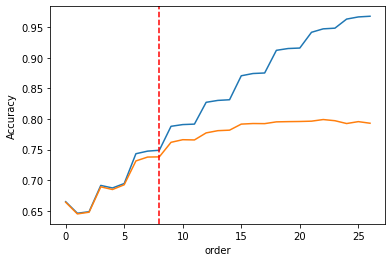

In [28]:
ans=pd.DataFrame(results['fatals'])
ans['mean_train_score'].plot()
ans['mean_test_score'].plot()
plt.xlabel('order')
plt.ylabel('Accuracy')
plt.axvline(x=8, linestyle='--', color='r')

In [29]:
ans['params'][8]

{'max_depth': 7, 'n_estimators': 90}

In [30]:
rf.set_params(max_depth=7, n_estimators=90, random_state=0)
rf.fit(X, fatals)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features=5,
                       max_leaf_nodes=None, max_samples=0.01,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

- Check the confusion matrix to make sure the trained classifier does perform.

In [31]:
from sklearn.metrics import confusion_matrix

confusion_matrix(fatals, rf.predict(X))

array([[1144288,  458484],
       [  93960,  442440]])

- Storing the random forest feature importances into a dictionary.

In [32]:
importances = {}
importances['fatals'] = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances['fatals']

Collision Type Descriptor        0.375784
Event Descriptor                 0.171171
Police Report                    0.089343
Number of Vehicles Involved      0.082124
Pedestrian Bicyclist Action      0.042597
Lighting Conditions              0.041799
Road Descriptor                  0.038572
DOT Reference Marker Location    0.035685
Traffic Control Device           0.030881
Hour                             0.025937
Weather Conditions               0.020463
Road Surface Conditions          0.014364
Municipality                     0.009851
County Name                      0.009027
Month                            0.007157
Day of Week                      0.003677
Year                             0.001570
dtype: float64

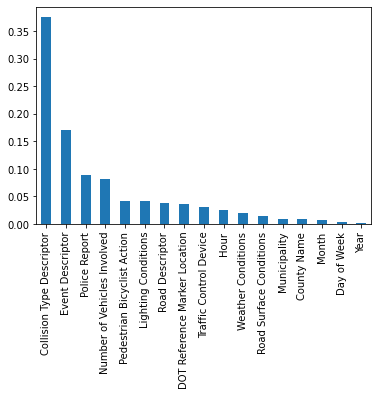

In [33]:
importances['fatals'].plot(kind='bar')

- Find the hyperparameter with reasonably small train-test performance discrepancy.

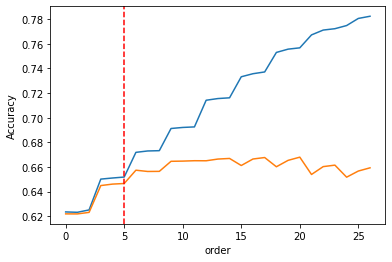

In [34]:
ans=pd.DataFrame(results['injuries'])
ans['mean_train_score'].plot()
ans['mean_test_score'].plot()
plt.xlabel('order')
plt.ylabel('Accuracy')
plt.axvline(x=5,linestyle='--', color='r')

In [35]:
ans['params'][5]

{'max_depth': 5, 'n_estimators': 90}

In [36]:
rf.set_params(max_depth=5, n_estimators=90, random_state=0)
rf.fit(X, injuries)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features=5,
                       max_leaf_nodes=None, max_samples=0.01,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

- Checking the confusion matrix for the performance of the model.

In [37]:
confusion_matrix(injuries, rf.predict(X))

array([[655172, 419246],
       [328002, 736752]])

- We notice that the feature importances of injuries are substaintially different from those of the fatalities. I.e. the top driving factors of fatalities are not the same as those of the
injuries.
- We store it in the **importances** dictionary.

In [38]:
importances['injuries'] = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances['injuries']

Traffic Control Device           0.252042
Collision Type Descriptor        0.175329
Number of Vehicles Involved      0.133514
Lighting Conditions              0.087494
Event Descriptor                 0.077422
Hour                             0.065588
DOT Reference Marker Location    0.053256
Pedestrian Bicyclist Action      0.044782
Road Descriptor                  0.042544
County Name                      0.026857
Municipality                     0.014779
Police Report                    0.011375
Weather Conditions               0.007563
Road Surface Conditions          0.003108
Month                            0.002210
Year                             0.001139
Day of Week                      0.001001
dtype: float64

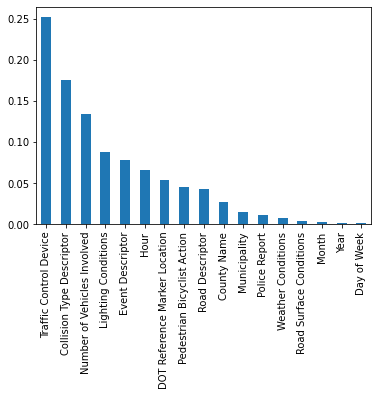

In [39]:
importances['injuries'].plot(kind='bar')

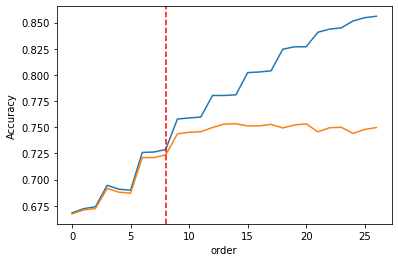

In [40]:
ans=pd.DataFrame(results['damages'])
ans['mean_train_score'].plot()
ans['mean_test_score'].plot()
plt.xlabel('order')
plt.ylabel('Accuracy')
plt.axvline(x=8, linestyle='--', color='r')

In [41]:
ans['params'][8]

{'max_depth': 7, 'n_estimators': 90}

In [42]:
rf.set_params(max_depth=7, n_estimators=90, random_state=0)
rf.fit(X, damages)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features=5,
                       max_leaf_nodes=None, max_samples=0.01,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

- Checking the confusion matrix for the performance of the random forest.

In [43]:
confusion_matrix(damages, rf.predict(X))

array([[607164, 479202],
       [104141, 948665]])

- Store the random forest feature importances into the **importances** dictionary.

In [44]:
importances['damages'] = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances['damages']

Pedestrian Bicyclist Action      0.308254
Event Descriptor                 0.302909
Collision Type Descriptor        0.084019
County Name                      0.060292
Number of Vehicles Involved      0.052489
Municipality                     0.032524
Weather Conditions               0.024928
Traffic Control Device           0.022899
Police Report                    0.021094
Lighting Conditions              0.017266
Road Surface Conditions          0.017225
DOT Reference Marker Location    0.016821
Road Descriptor                  0.015922
Hour                             0.012688
Month                            0.006761
Day of Week                      0.002604
Year                             0.001306
dtype: float64

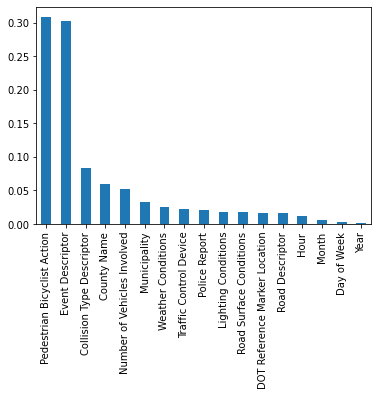

In [45]:
importances['damages'].plot(kind='bar')

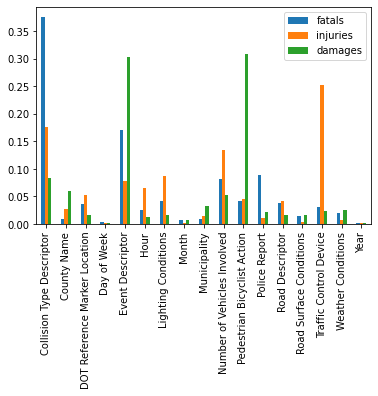

In [46]:
pd.DataFrame(importances).plot(kind='bar')

- The overall mean importances for **fatals**, **injuries** and **damages**.

In [47]:
pd.DataFrame(importances).mean(axis=1).sort_values(ascending=False)

Collision Type Descriptor        0.211711
Event Descriptor                 0.183834
Pedestrian Bicyclist Action      0.131878
Traffic Control Device           0.101940
Number of Vehicles Involved      0.089375
Lighting Conditions              0.048853
Police Report                    0.040604
DOT Reference Marker Location    0.035254
Hour                             0.034738
Road Descriptor                  0.032346
County Name                      0.032059
Municipality                     0.019051
Weather Conditions               0.017651
Road Surface Conditions          0.011565
Month                            0.005376
Day of Week                      0.002427
Year                             0.001339
dtype: float64

In [48]:
top_importances = {}
focus = 'fatals'

In [49]:
top_importances[focus] =importances[focus].index[:4]
print('The top four features has aggregate %.2f importance' %(importances[focus].iloc[:4].sum()))

The top four features has aggregate 0.72 importance


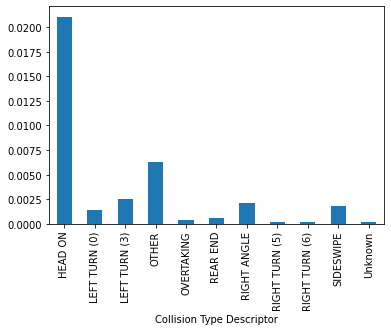

In [50]:
crashes['fatals'] = crashes['Crash Descriptor'].map(lambda t:t.find('Fatal')>-1)
crashes.groupby(top_importances[focus][0])[focus].mean().plot(kind='bar')

- We observe that the head-on collision is particularly dangerous.

'fatals'

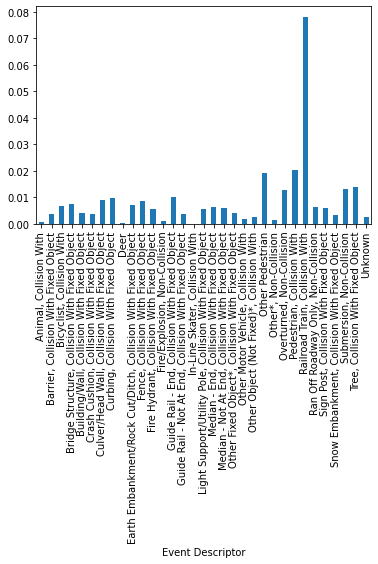

In [51]:
crashes.groupby(top_importances[focus][1])[focus].mean().plot(kind='bar')
focus

- It is observed that colliding with a train is super dangerous.

'fatals'

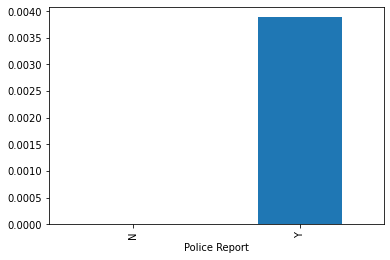

In [52]:
crashes.groupby(top_importances[focus][2])[focus].mean().plot(kind='bar')
focus

- When the police is not involved in a crash, the accident is not fatal.

'fatals'

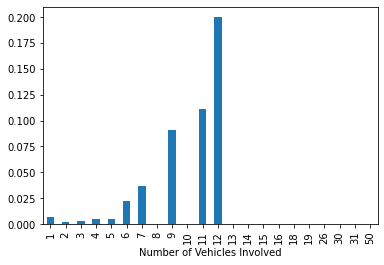

In [53]:
crashes.groupby(top_importances[focus][3])[focus].mean().plot(kind='bar')
focus

- The chain crash accident involving more than $8$ cars is very dangerous.

In [54]:
def DisplayInteraction(feature_1, feature_2, accident_type='fatals', xfontsize=None, yfontsize=None):
    interact_fatals   = crashes.groupby([feature_1, feature_2])[accident_type].mean().reset_index().pivot(index=feature_1, columns=feature_2, values=accident_type)
    sns.heatmap(interact_fatals, xticklabels=True, yticklabels=True)
    if xfontsize: plt.xticks(fontsize=xfontsize)
    if yfontsize: plt.yticks(fontsize=yfontsize)
        

- In the following heat map, the missing values are marked white while all the non-white colors represent different event-collision type combinations.
- We notice that for many combinations, the fatal rates are zero (black in the heat map).

In [55]:
DisplayInteraction(top_importances[focus][0], top_importances[focus][1], yfontsize=8)

- **Guided-Rail-End** right angle collision with an object, **Overturned** non-collision 
rear end damage have particularly high fatality rates, about $20\%$.

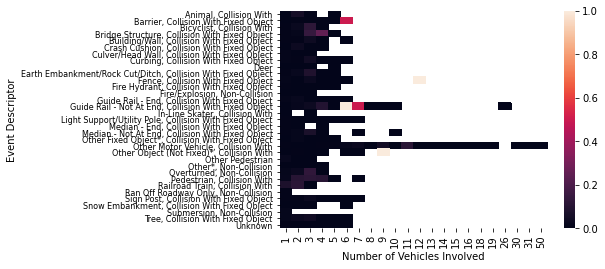

In [56]:
DisplayInteraction(top_importances[focus][1], top_importances[focus][3], yfontsize=8)

- **Collision with fence**, **Collision with other non-fixed object**, **Collision with guided rail**, all involving $>5$ cars, are very deadly with nearly $100\%$ chance to be fatal.


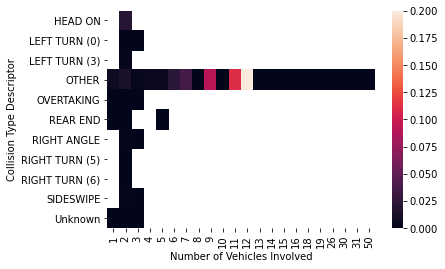

In [57]:
DisplayInteraction(top_importances[focus][0], top_importances[focus][3])

- In terms of **collision type descriptor**, only the 'other' uncategorized type involves a large number of vehicles in the collision. When the involving vehicles are $5-12$, the fatality rate increases.  The maximum $20\%$ occurs when there are $12$ vehicles in a chain collision.

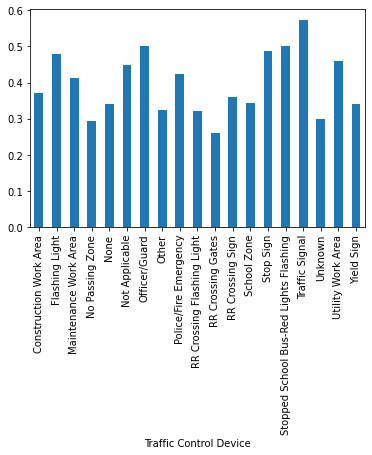

In [58]:
crashes['injuries'] = crashes['Crash Descriptor'].map(lambda t:t.find('Injury')>-1)
focus = 'injuries'
top_importances[focus]     = importances[focus].index[:4]
crashes.groupby(top_importances[focus][0])[focus].mean().plot(kind='bar')

- **Traffic Light** as a traffic control device has the highest injury collision rate.
- The rail-road crossing gate has the lowest injury rate.
- It is not scientific to conlude that **traffic light** is the contributing factor to the injuries.
Instead it is very likely that the traffic lights are set up because the crossing is dangerous.

In [59]:
print('The top four features has aggregate %.2f importance' %(importances[focus].iloc[:4].sum()))

The top four features has aggregate 0.65 importance


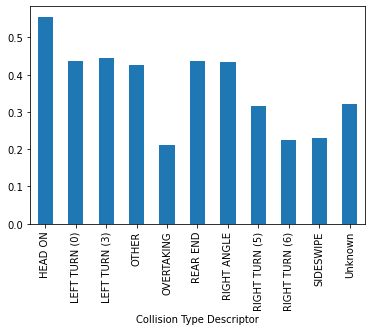

In [60]:
crashes.groupby(top_importances[focus][1])[focus].mean().plot(kind='bar')

- In terms of collision types, **Head On** collisions have the highest injury rates, while overtaking collisions have the lowest injury rates.

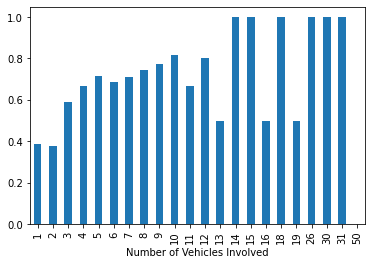

In [61]:
crashes.groupby(top_importances[focus][2])['injuries'].mean().plot(kind='bar')

- In terms of the number of vehicles involved, the collisions involving less than three vehicles
are less dangerous (in turns of injury rate) than those involving three or above vehicle.s
- With some exceptions, the collisions involving more than $13$ vehicles are having high injury rates.

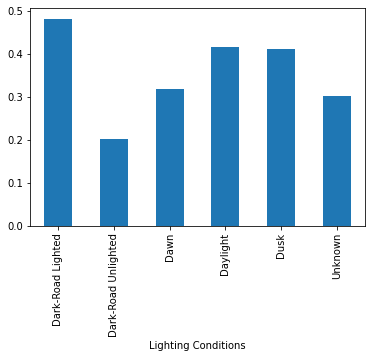

In [62]:
crashes.groupby(top_importances[focus][3])['injuries'].mean().plot(kind='bar')

- It is interesting to observe that the dark-road lighted light condition has the higest injury rate, while the dark-road unlighted light condition has the lowest injury rate.

In [63]:
DisplayInteraction(top_importances[focus][0], top_importances[focus][1], 'injuries')

- The white color cells above are missing collision-type vs traffic control device combinations.
- We notice that the **head-on** collision while the stopped school bus has its red light flashing
is a high injury risk collision event.
- Both **head-on** and the un-categorized **other** collisions are dangerous. For the **other** type,
the **traffic signal** and **officer/guard** are the two highest injury risk traffic control devices.

In [64]:
DisplayInteraction(top_importances[focus][0], top_importances[focus][2], 'injuries')

- For rail road crossing, school zone, utility work area, the number of involved vehicles is low.
- Over all we observe that when the number of involved vehicles increase (the collision is severe), the injury rate also gets higher.
- When there is no traffic control device (like the highway), the number of vehicles can grow to
$30$ and the injury rate grows high.


In [65]:
DisplayInteraction(top_importances[focus][0], top_importances[focus][3], 'injuries')

- When the lighting condition is un-determined, the collision injury rate tends to be high.
- Among those **lighting conditions** which are specified, railroad crossing at dawn and utilitiy work area at dawn are the magnets for injuries. The stoppped school bus with flashing red lights in the dark (with no lighting) is also a factor contributing to the injuries.

In [66]:
DisplayInteraction(top_importances[focus][1], top_importances[focus][2], 'injuries')

In [67]:
DisplayInteraction(top_importances[focus][1], top_importances[focus][3], 'injuries')

- Across different lighting conditions, the **head-on** collision has the highest injury rates, 
with the dawn and the dusk leading the pack.
- As we have oberved earlier, **lighted road** in the dark is more risky (in terms of injuries)
than **unlighted road**.
- The left turns are more dangerous than the right turns and sideswipe.
- Even though the collisions in the daylight are overall less dangerous (in terms of injuries) than the
other lighting conditions, it becomes more dangerous when the collision type is un-categorized (tagged **other**).

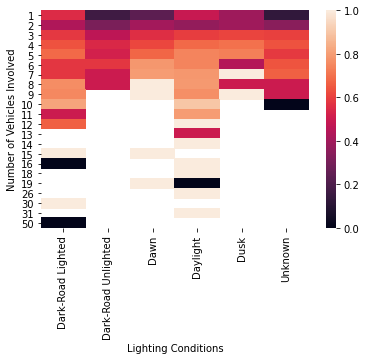

In [68]:
DisplayInteraction(top_importances[focus][2], top_importances[focus][3], 'injuries')

- We notice that **dawn**, **daylight** and **dark-road lighted** are the three breeding ground of
the high-vehicle-number collisions. When the involved vehicles are greater than $8$, the collisions are very likely to produce injuries.  This is not surprising in that those major newspaper worthy
collisions are very severe.

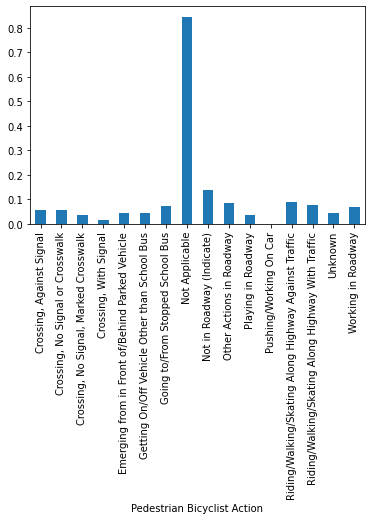

In [69]:
crashes['damages'] = crashes['Crash Descriptor'].map(lambda t:t.find('Property')>-1)
focus = 'damages'
top_importances[focus] = importances[focus].index[:4]
crashes.groupby(top_importances[focus][0])[focus].mean().plot(kind='bar')

- When the collision does not involve pedestrian nor bicyclist, the property damage rate spikes.

In [70]:
print('The top four features has aggregate %.2f importance' %(importances[focus].iloc[:4].sum()))

The top four features has aggregate 0.76 importance


In [71]:
crashes.groupby(top_importances[focus][1])[focus].mean().plot(kind='bar')

- It is not surprising that collisions with pedestrians or bicyclists are less prone to involve some property damage.
- All the collisions except colliding with pedestrians, bicyclists, skaters have at least $60\%$ chance to produce property damage.

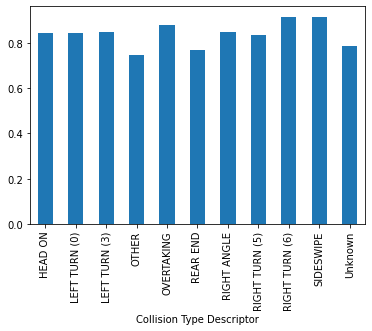

In [72]:
crashes.groupby(top_importances[focus][2])['damages'].mean().plot(kind='bar')

- Overall the property damage rate is high, with the right turn and sideswipe leading the pack.
- The rear end collision and the uncategorized 'other' are slightly less damaging. 

In [73]:
crashes.groupby(top_importances[focus][3])['damages'].mean().plot(kind='bar', fontsize=7)

In [74]:
t=crashes.groupby(top_importances[focus][3])['damages'].mean()
t[t<0.6]

County Name
BRONX       0.395884
KINGS       0.388289
NEW YORK    0.441206
QUEENS      0.471098
RICHMOND    0.537089
Name: damages, dtype: float64

- For most of the counties in the New York state, the property damage rates of the 
collisions are above $90\%$.
- Only the Bronx, Brooklyn (Kings), Manhattan (New York), and Queens have the luxury to have 
lower rates. It is probably because the roads are so-crowded that the vehicles travel with a lower speed.

'damages'

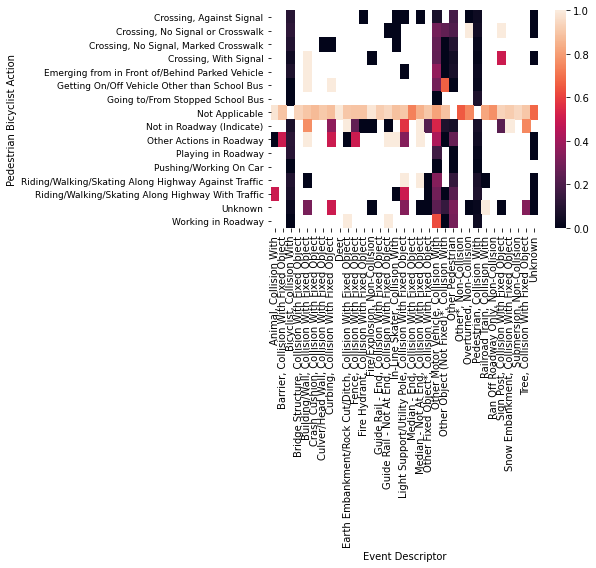

In [75]:
DisplayInteraction(top_importances[focus][0], top_importances[focus][1], focus, yfontsize=9)
focus

- In the interaction between pedestrian/Bicyclist action vs the collision event, we notice that many 
combinations are missing.
- Apparently non-pedestrian-bicyclist related collisions are the magnet to property damage.
Yet there are $17$ pedestrian-bicyclist related collisions which are prone to property damages.
- For example, while there are workers on the road, the collisions with rock/ditch/earth embankment/guided rail are always causing property damage.
- When a pedestrian or a skater moves against the high way traffic, the vehicle tries to avoid
hitting the pedestrian/skater and hits a light-pole or the other fixed object on the road.

In [76]:
mean = crashes.groupby([top_importances[focus][0], top_importances[focus][1]])['damages'].mean()
mean[mean>0.99].reset_index()

Pedestrian Bicyclist Action  \
0                    Crossing, No Signal or Crosswalk   
1                    Crossing, No Signal or Crosswalk   
2                               Crossing, With Signal   
3     Emerging from in Front of/Behind Parked Vehicle   
4        Getting On/Off Vehicle Other than School Bus   
5        Getting On/Off Vehicle Other than School Bus   
6                           Not in Roadway (Indicate)   
7                           Not in Roadway (Indicate)   
8                           Not in Roadway (Indicate)   
9                            Other Actions in Roadway   
10                           Other Actions in Roadway   
11                           Other Actions in Roadway   
12                           Other Actions in Roadway   
13  Riding/Walking/Skating Along Highway Against T...   
14  Riding/Walking/Skating Along Highway Against T...   
15                                            Unknown   
16                                 Working in Roadway   
17                                 Working in Roadway   

                                     Event Descriptor  damages  
0                           Overturned, Non-Collision      1.0  
1              Sign Post, Collision With Fixed Object      1.0  
2          Building/Wall, Collision With Fixed Object      1.0  
3          Building/Wall, Collision With Fixed Object      1.0  
4          Building/Wall, Collision With Fixed Object      1.0  
5                Curbing, Collision With Fixed Object      1.0  
6   Earth Embankment/Rock Cut/Ditch, Collision Wit...      1.0  
7    Median - Not At End, Collision With Fixed Object      1.0  
8        Snow Embankment, Collision With Fixed Object      1.0  
9          Building/Wall, Collision With Fixed Object      1.0  
10  Guide Rail - Not At End, Collision With Fixed ...      1.0  
11                     In-Line Skater, Collision With      1.0  
12   Median - Not At End, Collision With Fixed Object      1.0  
13  Light Support/Utility Pole, Collision With Fix...      1.0  
14   Median - Not At End, Collision With Fixed Object      1.0  
15                     Railroad Train, Collision With      1.0  
16  Earth Embankment/Rock Cut/Ditch, Collision Wit...      1.0  
17  Guide Rail - Not At End, Collision With Fixed ...      1.0

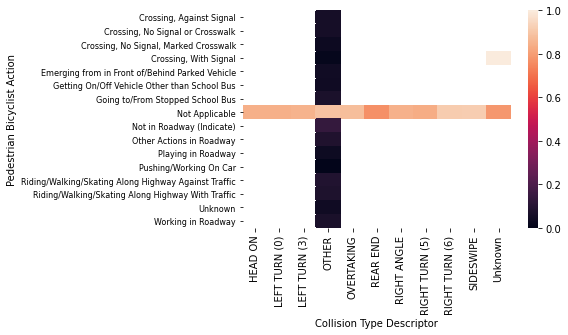

In [77]:
DisplayInteraction(top_importances[focus][0], top_importances[focus][2], 'damages', yfontsize=8)

'damages'

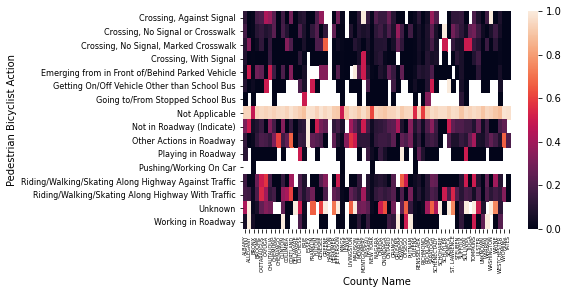

In [78]:
DisplayInteraction(top_importances[focus][0], top_importances[focus][3], focus, xfontsize=5, yfontsize=8)
focus

'damages'

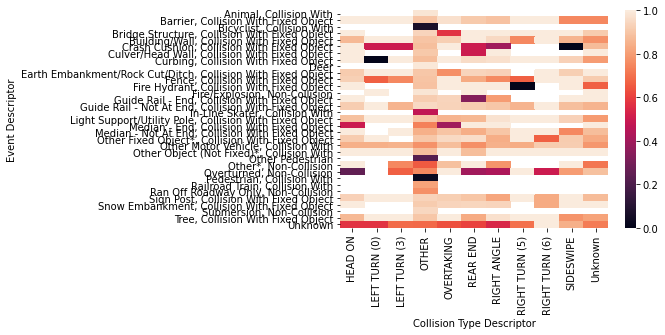

In [79]:
DisplayInteraction(top_importances[focus][1], top_importances[focus][2], focus)
focus

- Besides the missing combinations, overall the rate of property damage is high $>50\%$.
- There are a few exceptions like left turn hitting a curb, right turn colliding with a fire hydrant, sideswipe hitting
the crash-cushion, or a collision with a bicyclist, which produce no property damage.

'damages'

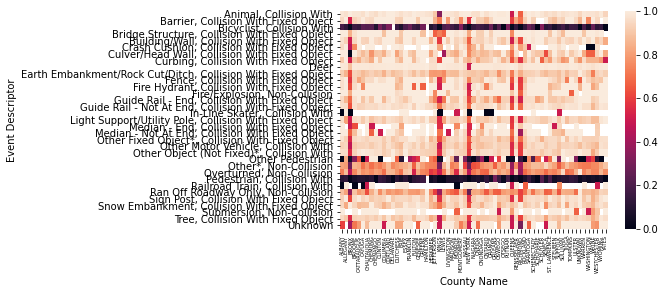

In [80]:
DisplayInteraction(top_importances[focus][1], top_importances[focus][3], focus, xfontsize=5)
focus

- Colliding with pedestrians, or bicyclists are low risk events in terms of property damages.
- Overall, collisions in the $5$ **NYC** boroughs have lower property damage rates.
- But this conclusion doesn't apply to collision with deers, which still have $>90\% property damage rates in 
the **NYC** boroughs.
- As about the collisions with the animals, only those in **Queens**, **Brooklyn**, **Stanten Island**
occur with low (property damage) rate, not those in **Manhattan** or **Bronx**.

'damages'

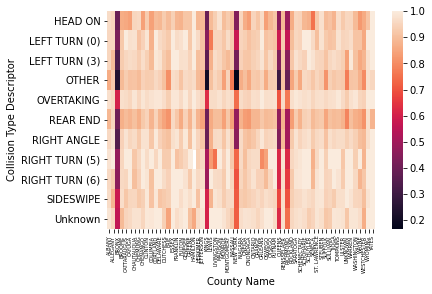

In [81]:
DisplayInteraction(top_importances[focus][2], top_importances[focus][3], focus, xfontsize=5)
focus

- It is visible that the $5$ boroughs of **NYC** have much lower property damage rates than the others.
- We also observe that westchester county has lower rate across multiple collision types.
- We also observe that rear end, head on and the un-categorized collisions have lower property damage rates.
- For a given collision type like **head-on**, the property damage rate usually fluctuates in-between
$50\%$ to $100\%$ across different counties outside the $5$ **NYC** boroughs. 

### The Conclusion 
- In the above analysis, we have identified many feature-feature interactions surrounding the crash
events.
- Even though the analysis itself has nothing to do with machine learning, **random forest** along with
its feature importances allow us to focus upon the most important features, saving us energy from
analyzing less relevant features. 
- The feature-importances scores depend on the objectives 
(fatalities, injuries or property damages) we set up. For different objectives we focus on the
most relevant features, aligning our analysis with the corresponding objective.
- This maximizes our chance to derive useful insights down the road, which is difficult to achieve
using a bottom-up approach.